In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
%matplotlib inline

GPU acceleration enabled
using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [2]:
f = ppy.instrument.default_m49_filters()

In [3]:
%%time
iso_model = ppy.isochrones.Isochrone_Model(f)

CPU times: user 13.9 s, sys: 2.74 s, total: 16.7 s
Wall time: 17.1 s


In [4]:
driv = ppy.driver.Driver(iso_model, gpu=True)

In [5]:
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'

In [6]:
pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t23_z-gz.pcmd', unpack=True)
dmod_m49 = 31.3

In [7]:
gal_m49 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)

In [64]:
res = {}
thin_regions = [23, 48, 70]
for r in thin_regions:
    try:
        res['t{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/m49_taufull-thin_t{:d}.csv'.format(r),
                                                            run_name='Region {:d}'.format(r))
        res['t{:d}_nm'.format(r)] = ppy.plotting.ResultsPlotter('results/m49_taunomu-thin_t{:d}.csv'.format(r),
                                                            run_name='Region {:d} (Distance Fixed)'.format(r))
    except:
        print('t{:d} not found'.format(r))        

for r in thin_regions:
    try:
        res['g{:d}'.format(r)] = ppy.plotting.ResultsPlotter('results/m49_taugauss_t{:d}.csv'.format(r),
                                                            run_name='Gauss Region {:d}'.format(r))
    except:
        print('g{:d} not found'.format(r))        
        

In [9]:
for t in thin_regions:
    res['t{:d}_nm'.format(t)].df['dmod'] = 31.3

In [10]:
xmax = np.max([len(r.df) for r in res.values()])
print(xmax)

12939


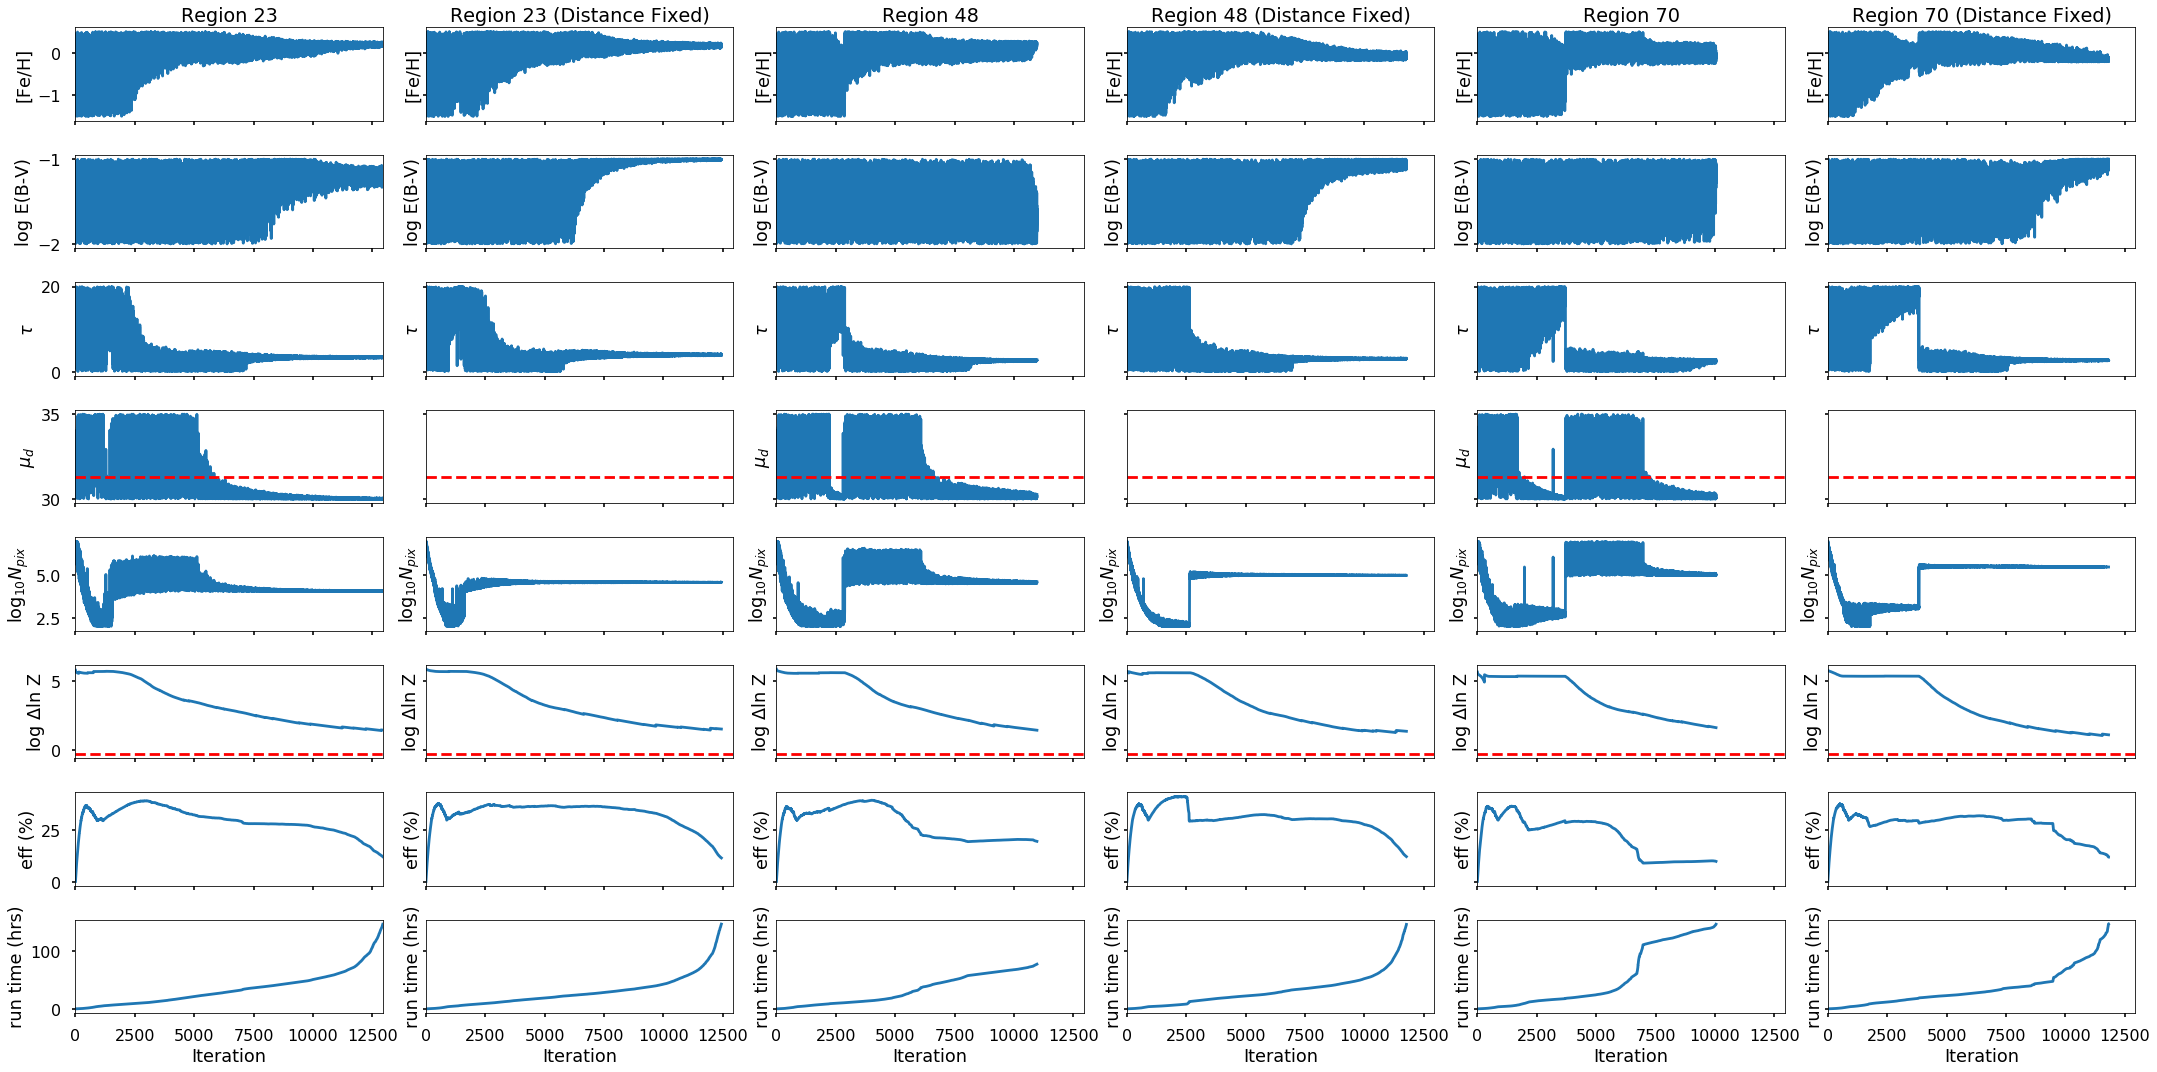

In [11]:
%%time
fig, axes = plt.subplots(ncols=2*len(thin_regions), nrows=8, figsize=(30,15), sharex=True, sharey='row')
for i, r in enumerate(thin_regions):
    res['t{:d}'.format(r)].plot_chains(axes=axes[:,2*i])
#     res['r{:d}_wd'.format(r)].plot_chains(axes=axes[:,3*i+1])
    res['t{:d}_nm'.format(r)].plot_chains(axes=axes[np.array([0,1,2,4,5,6,7]),2*i+1])
    for j in range(2):
        axes[3,j+2*i].axhline(y=31.3, ls='--', color='r')
axes[0,0].set_xlim(xmax=xmax)
plt.tight_layout()

CPU times: user 1.27 s, sys: 15.9 ms, total: 1.29 s
Wall time: 1.52 s


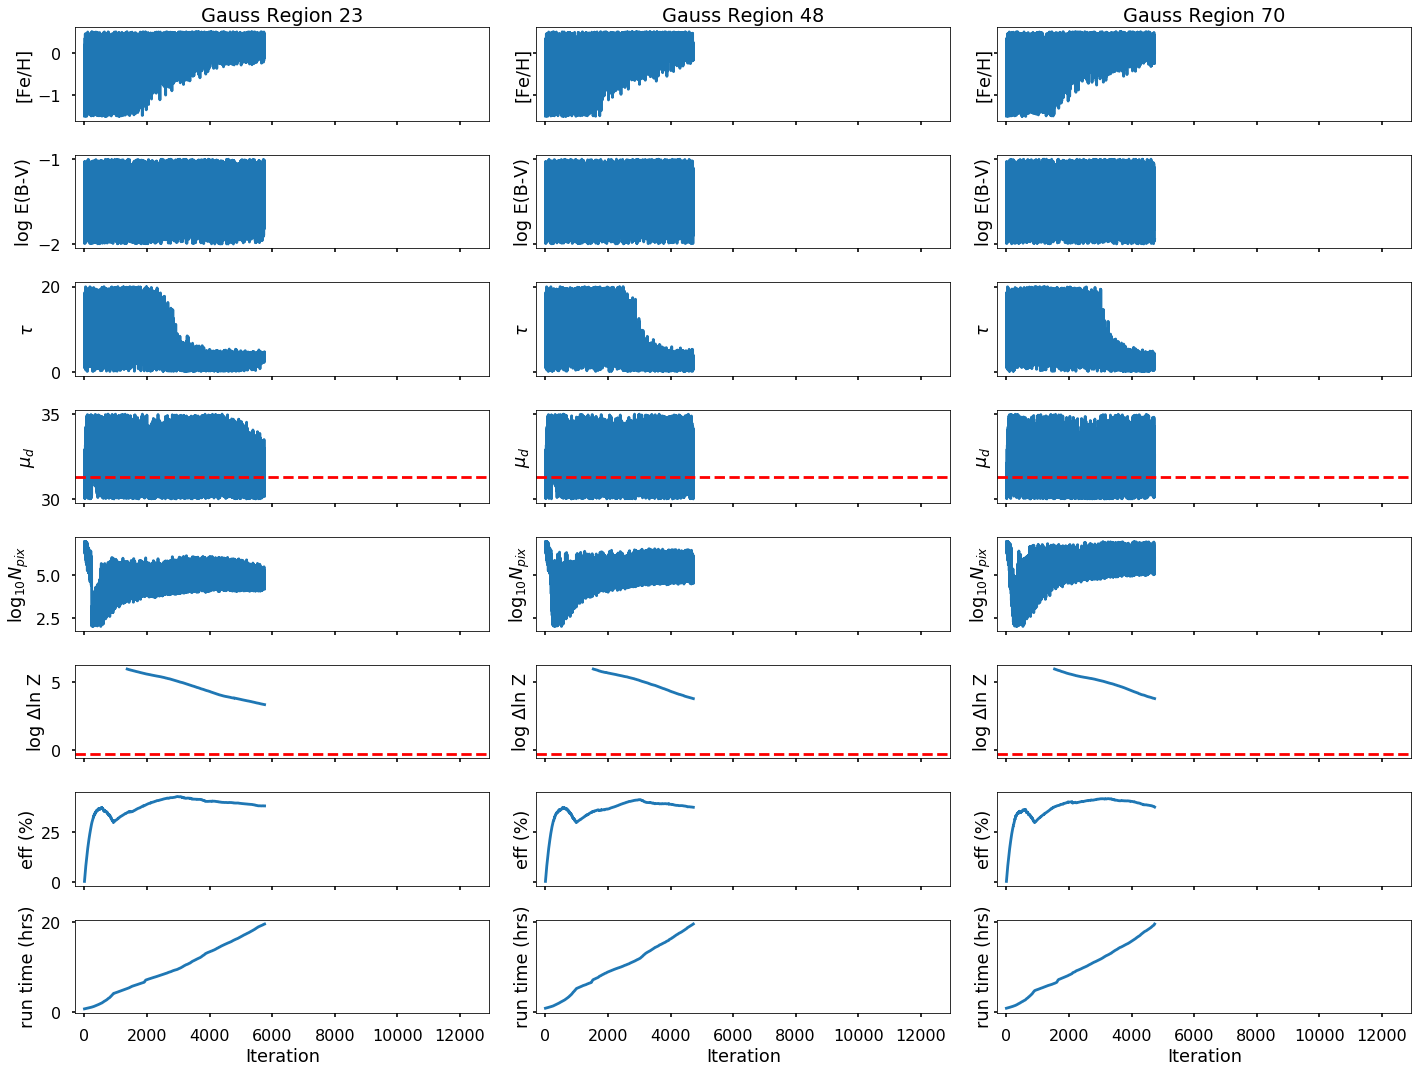

In [65]:
%%time
fig, axes = plt.subplots(ncols=len(thin_regions), nrows=8, figsize=(20,15), sharex=True, sharey='row')
for i, r in enumerate(thin_regions):
    res['g{:d}'.format(r)].plot_chains(axes=axes[:,i])
    axes[3,i].axhline(y=31.3, ls='--', color='r')
axes[0,0].set_xlim(xmax=xmax)
plt.tight_layout()

# Compare Results

In [13]:
exposure_ratio = 1.
f[0]._exposure = 560 * exposure_ratio
f[1]._exposure = 375 * exposure_ratio
sky_m49 = np.array([30.0, 27.6])*exposure_ratio
downsample=5

In [14]:
def best_params(run_name):
    return res[run_name].df.tail(1)[['logfeh_mean', 'logdust', 'logNpix', 'tau', 'dmod']].values[0]

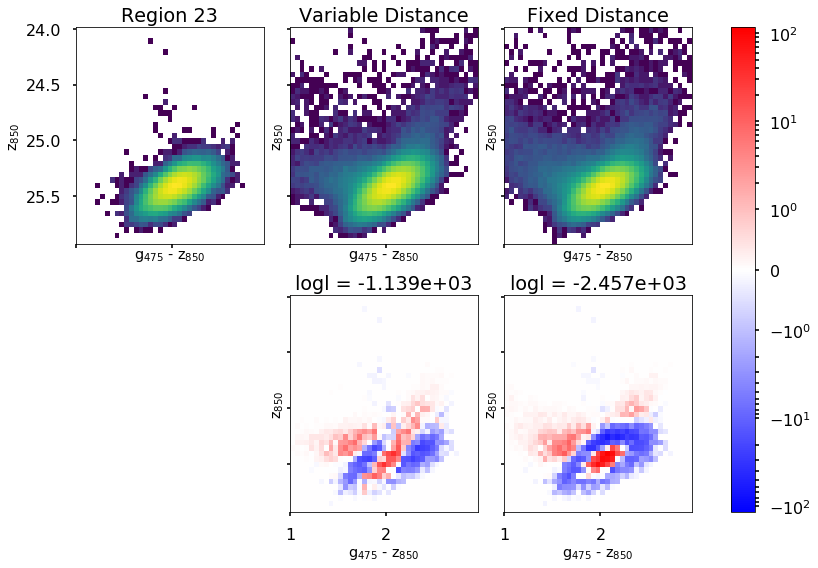

In [40]:
bins = None
reg_id = 23
pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t{:d}_z-gz.pcmd'.format(reg_id), unpack=True)
if bins is None:
    bins = [np.arange(1, 3, 0.05), np.arange(min(pcmd_m49[0])-.1, max(pcmd_m49[0])+.1, 0.05)]
driv.initialize_data(pcmd_m49, bins=bins[::-1], boundary=False)

gal_m49.set_params(best_params('t{:d}'.format(reg_id)))
pcmd_float = driv.simulate(gal_m49, 1024, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]

gal_m49.set_params(best_params('t{:d}_nm'.format(reg_id)))
pcmd_fixed = driv.simulate(gal_m49, 1024, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]

loglike_float = driv.loglike_map(pcmd_float)[0]
loglike_fixed = driv.loglike_map(pcmd_fixed)[0]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=True, sharey=True)

vm = np.max(np.abs(np.append(loglike_float.flatten(), loglike_fixed.flatten())))

axes[0,0].hist2d(pcmd_m49[1], pcmd_m49[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,0].set_title('Region {:d}'.format(reg_id))
axes[0,1].hist2d(pcmd_float[1], pcmd_float[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].set_title('Variable Distance')
axes[0,2].hist2d(pcmd_fixed[1], pcmd_fixed[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,2].set_title('Fixed Distance')

axes[1,0].axis('off')

plt.subplot(axes[1,1])
plt.imshow(loglike_float, extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
axes[1,1].set_title('logl = {:.3e}'.format(-np.abs(loglike_float).sum()))

plt.subplot(axes[1,2])
plt.imshow(loglike_fixed, extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
axes[1,2].set_title('logl = {:.3e}'.format(-np.abs(loglike_fixed).sum()))

for ax in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)

plt.tight_layout()
plt.colorbar(ax=axes)


In [41]:
def make_compare_plot(reg_id, bins=None, n_im=1024):
    
    pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t{:d}_z-gz.pcmd'.format(reg_id), unpack=True)
    if bins is None:
        bins = [np.arange(1, 3, 0.05), np.arange(min(pcmd_m49[0])-.1, max(pcmd_m49[0])+.1, 0.05)]
    driv.initialize_data(pcmd_m49, bins=bins[::-1], boundary=False)
    
    gal_m49.set_params(best_params('t{:d}'.format(reg_id)))
    pcmd_float = driv.simulate(gal_m49, n_im, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]

    gal_m49.set_params(best_params('t{:d}_nm'.format(reg_id)))
    pcmd_fixed = driv.simulate(gal_m49, n_im, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]
    
    loglike_float = driv.loglike_map(pcmd_float)[0]
    loglike_fixed = driv.loglike_map(pcmd_fixed)[0]
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=True, sharey=True)

    vm = np.max(np.abs(np.append(loglike_float.flatten(), loglike_fixed.flatten())))

    axes[0,0].hist2d(pcmd_m49[1], pcmd_m49[0], bins=bins, norm=mpl.colors.LogNorm())
    axes[0,0].set_title('Region {:d}'.format(reg_id))
    axes[0,1].hist2d(pcmd_float[1], pcmd_float[0], bins=bins, norm=mpl.colors.LogNorm())
    axes[0,1].set_title('Variable Distance')
    axes[0,2].hist2d(pcmd_fixed[1], pcmd_fixed[0], bins=bins, norm=mpl.colors.LogNorm())
    axes[0,2].set_title('Fixed Distance')

    axes[1,0].axis('off')

    plt.subplot(axes[1,1])
    plt.imshow(loglike_float, extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
    axes[1,1].set_title('logl = {:.3e}'.format(-np.abs(loglike_float).sum()))

    plt.subplot(axes[1,2])
    plt.imshow(loglike_fixed, extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
    axes[1,2].set_title('logl = {:.3e}'.format(-np.abs(loglike_fixed).sum()))

    for ax in axes.flatten():
        ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)

    plt.tight_layout()
    plt.colorbar(ax=axes, label='Log Likelihood')


CPU times: user 9.14 s, sys: 1.73 s, total: 10.9 s
Wall time: 12 s


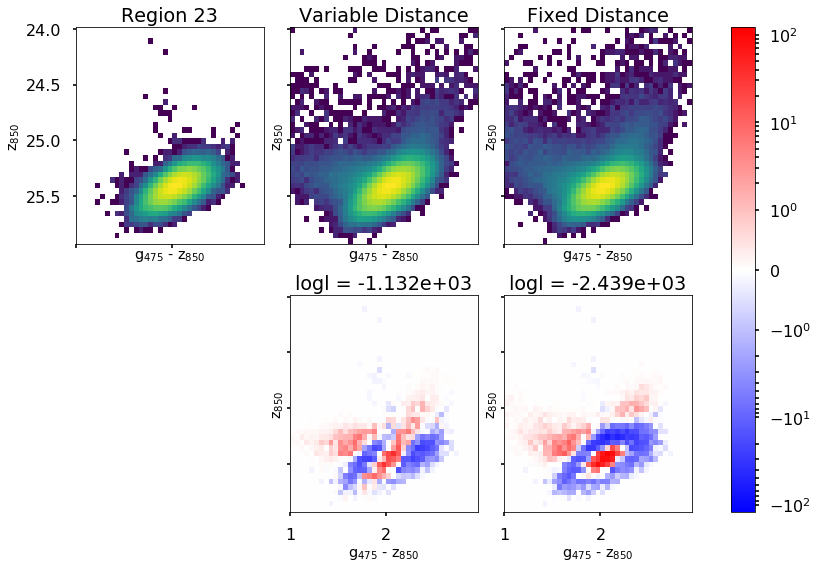

In [42]:
%%time
make_compare_plot(23)

CPU times: user 9.63 s, sys: 2.02 s, total: 11.6 s
Wall time: 12.6 s


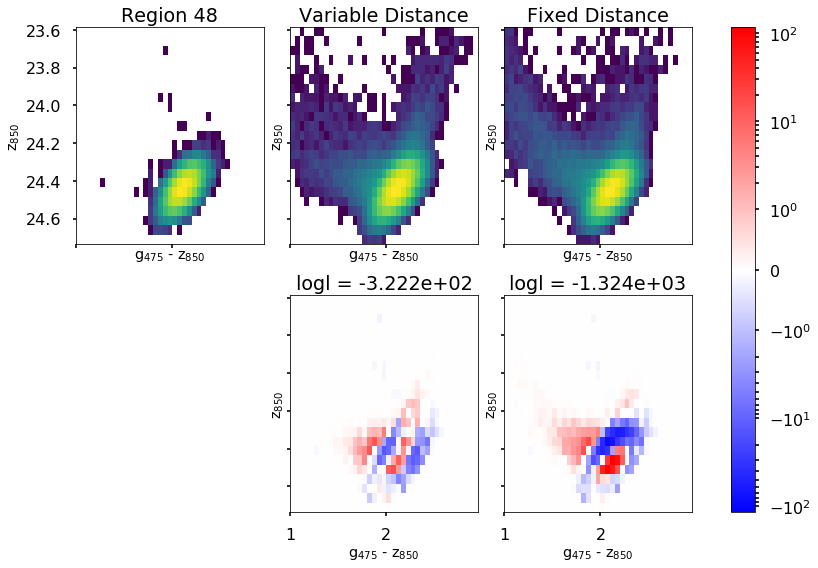

In [43]:
%%time
make_compare_plot(48)

CPU times: user 8.8 s, sys: 1.92 s, total: 10.7 s
Wall time: 11.7 s


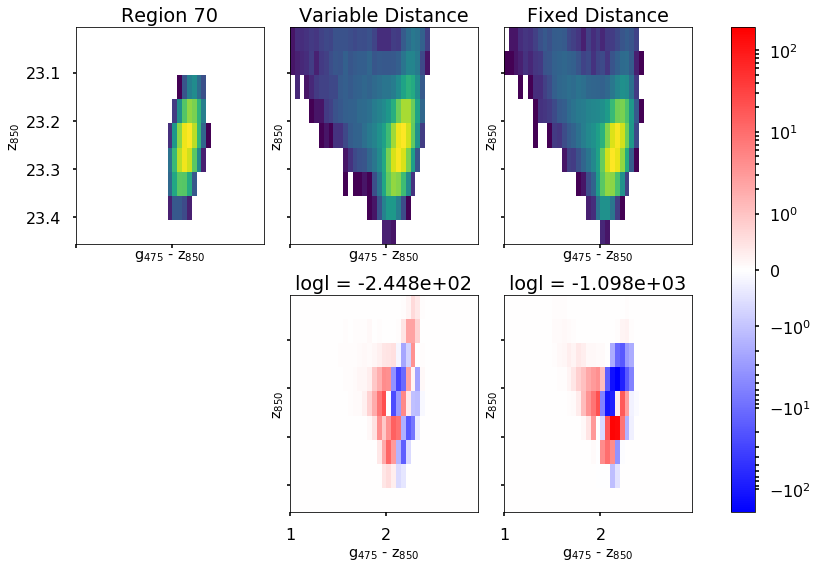

In [44]:
%%time
make_compare_plot(70)

In [55]:
def simulate_exposure(exposure_ratio=1., reg_id=23, n_im=1024, bins=None):
    f[0]._exposure = 560. * exposure_ratio
    f[1]._exposure = 375. * exposure_ratio
    sky_m49 = np.array([30.0, 27.6])*exposure_ratio

    pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t{:d}_z-gz.pcmd'.format(reg_id), unpack=True)
    if bins is None:
        bins = [np.arange(1, 3, 0.05), np.arange(min(pcmd_m49[0])-.1, max(pcmd_m49[0])+.1, 0.05)]
    
    gal_m49.set_params(best_params('t{:d}'.format(reg_id)))
    pcmd_float = driv.simulate(gal_m49, n_im, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]

    driv.initialize_data(pcmd_float, bins=bins[::-1], boundary=False)

    gal_m49.set_params(best_params('t{:d}_nm'.format(reg_id)))
    pcmd_fixed = driv.simulate(gal_m49, n_im, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]
    
    diff_map = driv.loglike_map(pcmd_fixed)[0]
    vm = np.max(np.abs(diff_map))
    
    fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharex=True, sharey=True)
    
    axes[0].hist2d(pcmd_float[1], pcmd_float[0], bins=bins, norm=mpl.colors.LogNorm())
    axes[0].set_title('Wrong Distance'.format(reg_id))
    plt.subplot(axes[1])
    plt.imshow(diff_map, extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
    axes[1].set_title('Difference (Exposure x {:.1f})'.format(exposure_ratio))
    axes[2].hist2d(pcmd_fixed[1], pcmd_fixed[0], bins=bins, norm=mpl.colors.LogNorm())
    axes[2].set_title('Correct Distance')

    for ax in axes.flatten():
        ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)

    plt.tight_layout()
    plt.colorbar(ax=axes, label='Log Likelihood')
    
    f[0]._exposure = 560.
    f[1]._exposure = 375.

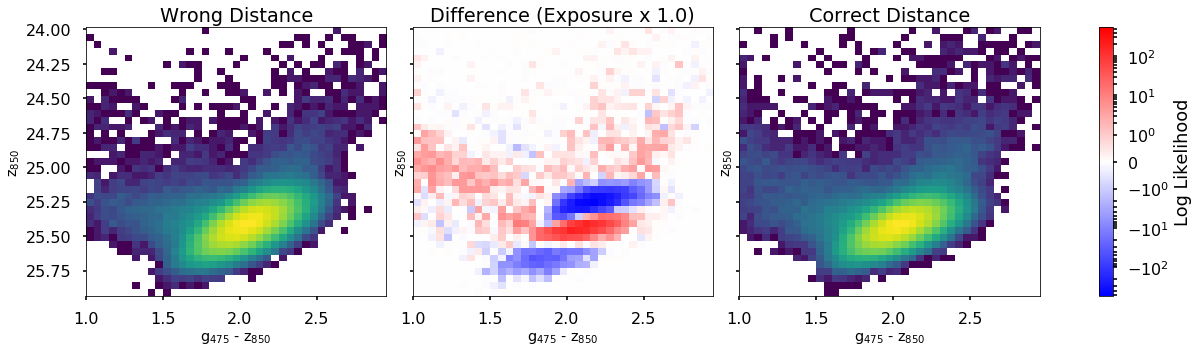

In [56]:
simulate_exposure(1., n_im=1024)

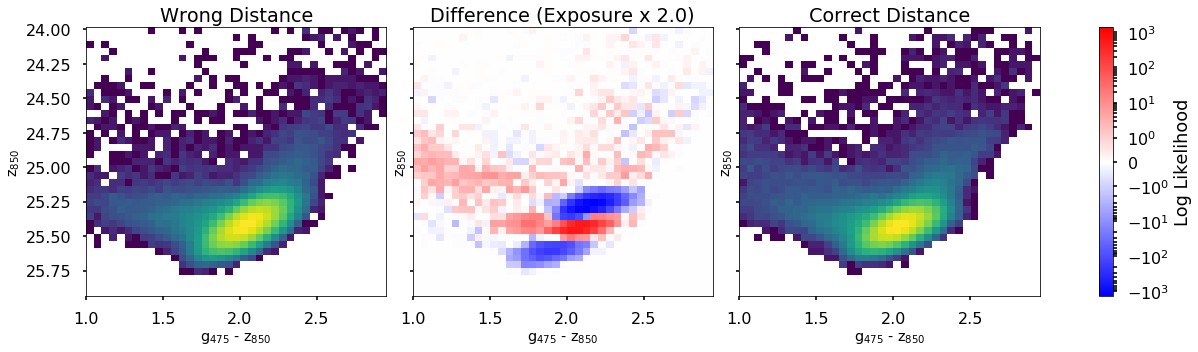

In [57]:
simulate_exposure(2., n_im=1024)

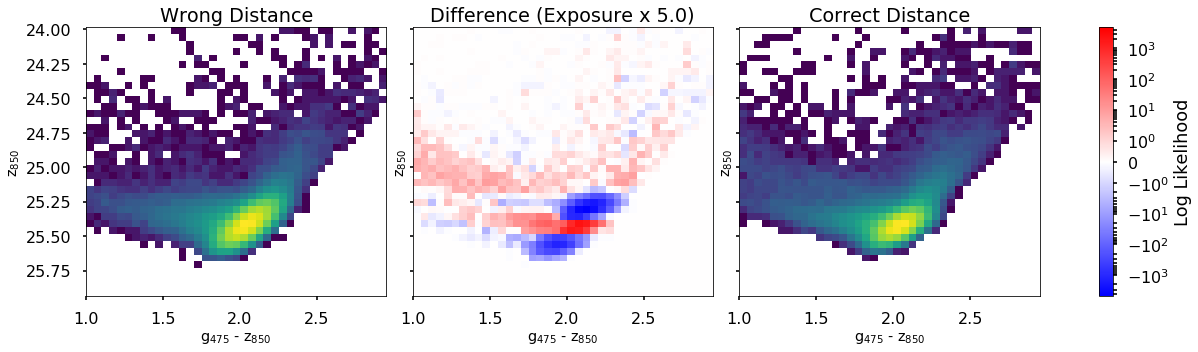

In [58]:
simulate_exposure(5., n_im=1024)

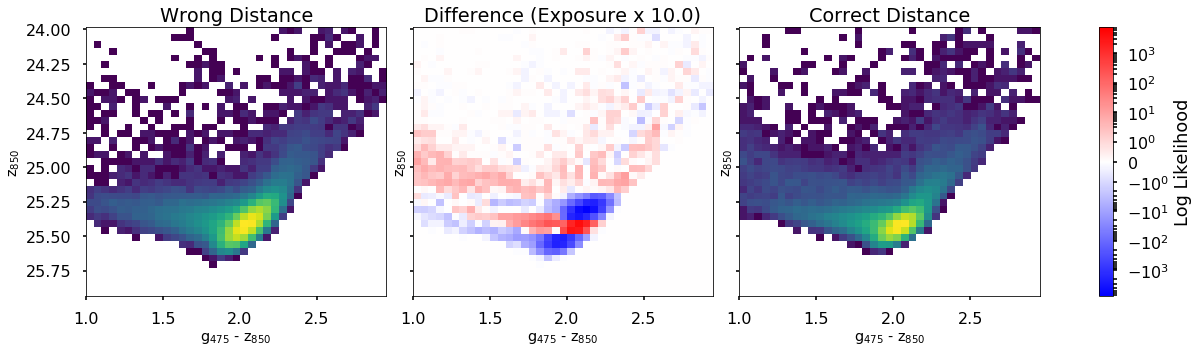

In [59]:
simulate_exposure(10., n_im=1024)

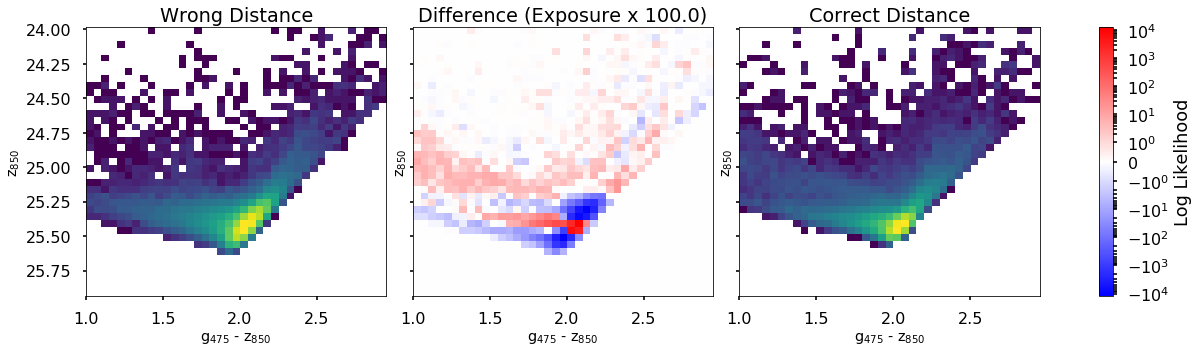

In [60]:
simulate_exposure(100., n_im=1024)